<a href="https://colab.research.google.com/github/Simo56a0/machineLEARNING/blob/master/gscnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral tensorflow numpy opencv-python scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/DATASET_ug_sign_language'
files_in_folder = os.listdir(folder_path)
print(files_in_folder)


['sign_annotations.csv', 'videos', '.ipynb_checkpoints', 'checkpoint.txt', 'frames1', 'resized_frames', 'normalized_frames', 'encoded_sign_labels.csv']


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# ✅ Set Paths Based on Your Dataset Structure
DATASET_PATH = "/content/drive/MyDrive/DATASET_ug_sign_language"
FRAMES_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/DATASET_ug_sign_language/resized_frames")  # Use resized frames to save memory
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/DATASET_ug_sign_language/encoded_sign_labels.csv")  # Directly using your encoded labels

# ✅ Reduce Image Size & Batch Size to Prevent Crashes
IMG_SIZE = 64  # Reducing from 224x224 to optimize memory
BATCH_SIZE = 8  # Small batch size prevents out-of-memory errors

# ✅ Load Pre-Encoded Labels
df = pd.read_csv(ANNOTATIONS_PATH)

# ✅ Verify Data
print(df.head())  # Ensure we are loading the correct file

# ✅ Extract X (frames) and Y (pre-encoded labels)
X, Y = [], []

for index, row in df.iterrows():
    video_id = row['video_ID']
    label = row['encoded_label']  # Directly using pre-encoded labels

    # ✅ Load All Frames for Each Video
    frame_files = sorted([f for f in os.listdir(FRAMES_PATH) if f.startswith(f"{video_id}_")])

    for frame_file in frame_files:
        frame_path = os.path.join(FRAMES_PATH, frame_file)
        img = cv2.imread(frame_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Resize & Normalize
        X.append(img)
        Y.append(label)

# ✅ Convert to NumPy Arrays
X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="int")

# ✅ Ensure `Y` matches `X`
Y = Y[:len(X)]
NUM_CLASSES = len(np.unique(Y))

# ✅ One-Hot Encode Labels (Since They Are Already Encoded)
Y = to_categorical(Y, num_classes=NUM_CLASSES)

# ✅ Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ✅ Use ImageDataGenerator to Load in Small Batches (Prevents Crashes)
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

print(f"✅ Training Samples: {X_train.shape}, Testing Samples: {X_test.shape}")


   video_ID sign_word  encoded_label
0  0001.mp4     hello             28
1  0002.mp4       you             84
2  0003.mp4       how             31
3  0004.mp4      name             46
4  0005.mp4      what             78
✅ Training Samples: (3397, 64, 64, 3), Testing Samples: (850, 64, 64, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

def build_gscnn(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")

    # ✅ Unfreeze last 50% of layers for fine-tuning
    for layer in base_model.layers[:100]:  # First 100 layers stay frozen
        layer.trainable = False
    for layer in base_model.layers[100:]:  # Last layers are trainable
        layer.trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = Flatten()(x)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Prevent overfitting
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ✅ Initialize Model
gscnn_model = build_gscnn(input_shape=(64, 64, 3), num_classes=85)
gscnn_model.summary()


<ipython-input-25-8c1755fa05f2>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 85)                  │          21,845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,590,805 (13.70 MB)

 Trainable params: 3,194,261 (12.19 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Optimized Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,      # Reduce rotation (avoid over-distorting hand shapes)
    zoom_range=0.1,         # Smaller zoom
    horizontal_flip=False,  # Do NOT flip (left vs. right-hand signs are different)
    width_shift_range=0.05, # Small shifts to avoid misalignment
    height_shift_range=0.05
)

test_datagen = ImageDataGenerator()  # No augmentation for test set

# ✅ Apply augmentation to training & testing data
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)  # Increase batch size
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Prevent Overfitting & Optimize Learning
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint("/content/gscnn_best_model.keras", save_best_only=True, monitor='val_loss', mode='min')

# ✅ Train Model (Prevent Crashes & Overfitting)
gscnn_model.fit(train_generator, validation_data=test_generator, epochs=30, batch_size=32, callbacks=[early_stopping, reduce_lr, checkpoint])


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.0151 - loss: 10.2717 - val_accuracy: 0.0059 - val_loss: 9.2494 - learning_rate: 5.0000e-05
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.0399 - loss: 9.1648 - val_accuracy: 0.0176 - val_loss: 9.0128 - learning_rate: 5.0000e-05
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.0555 - loss: 8.8493 - val_accuracy: 0.0365 - val_loss: 8.7721 - learning_rate: 5.0000e-05
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.0913 - loss: 8.6022 - val_accuracy: 0.0624 - val_loss: 8.5068 - learning_rate: 5.0000e-05
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1204 - loss: 8.2798 - val_accuracy: 0.0918 - val_loss: 8.1847 - learning_rate: 5.0000e-05
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1550 - loss: 7.9399 - val_accuracy: 0.1106 - val_loss: 7.8996 - learning_rate: 5.0000e-05
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step 

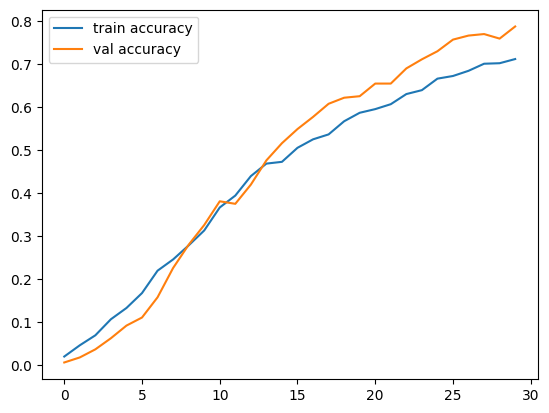

In [ ]:
import matplotlib.pyplot as plt

history = gscnn_model.history.history

plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()


In [ ]:
# ✅ Fine-Tuned Model (Unfreeze MobileNetV2)
gscnn_model = build_gscnn(input_shape=(64, 64, 3), num_classes=85)

# ✅ Optimized Data Augmentation
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)

# ✅ Train Model
gscnn_model.fit(train_generator, validation_data=test_generator, epochs=30, batch_size=32, callbacks=[early_stopping, reduce_lr, checkpoint])


<ipython-input-25-8c1755fa05f2>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.0179 - loss: 10.2412 - val_accuracy: 0.0318 - val_loss: 9.1909 - learning_rate: 5.0000e-05
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.0465 - loss: 9.1900 - val_accuracy: 0.0341 - val_loss: 8.9287 - learning_rate: 5.0000e-05
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.0785 - loss: 8.7823 - val_accuracy: 0.0624 - val_loss: 8.6906 - learning_rate: 5.0000e-05
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0944 - loss: 8.5498 - val_accuracy: 0.0929 - val_loss: 8.3930 - learning_rate: 5.0000e-05
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1276 - loss: 8.2130 - val_accuracy: 0.1341 - val_loss: 8.0961 - learning_rate: 5.0000e-05
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1730 - loss: 7.8717 - val_accuracy: 0.1576 - val_loss: 7.8328 - learning_rate: 5.0000e-05
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - 

In [ ]:
# Save the trained model
gscnn_model.save("gscnn_sign_language_model.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
gscnn_model = load_model("gscnn_sign_language_model.h5")
print("✅ Model Loaded Successfully!")

# Evaluate on test set
test_loss, test_accuracy = gscnn_model.evaluate(test_generator, verbose=1)

print(f"📌 Test Accuracy: {test_accuracy:.4f}")
print(f"📌 Test Loss: {test_loss:.4f}")


✅ Model Loaded Successfully!
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7686 - loss: 3.0064
📌 Test Accuracy: 0.7741
📌 Test Loss: 3.0335


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
model = load_model("gscnn_sign_language_model.h5")
# Get predictions
y_pred_probs = model.predict(X_test)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(Y_test, axis=1)  # True labels

# Class labels (Ensure you replace this with actual sign language labels)
class_labels = [f"Sign_{i}" for i in range(Y_test.shape[1])]

# Compute and print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
              precision    recall  f1-score   support

      Sign_0       0.90      1.00      0.95         9
      Sign_1       0.75      0.86      0.80        14
      Sign_2       0.00      0.00      0.00         2
      Sign_3       0.88      0.78      0.82        18
      Sign_4       0.83      0.56      0.67         9
      Sign_5       0.75      1.00      0.86         9
      Sign_6       0.83      1.00      0.91        10
      Sign_7       1.00      1.00      1.00         1
      Sign_8       0.73      1.00      0.84         8
      Sign_9       1.00      1.00      1.00        13
     Sign_10       1.00      0.56      0.71         9
     Sign_11       1.00      1.00      1.00         4
     Sign_12       0.67      0.86      0.75         7
     Sign_13       0.74      0.85      0.79        27
     Sign_14       1.00      0.33      0.50         6
     Sign_15       1.00      0.71      0.83         7
     Sign_16       1.00      0.53      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


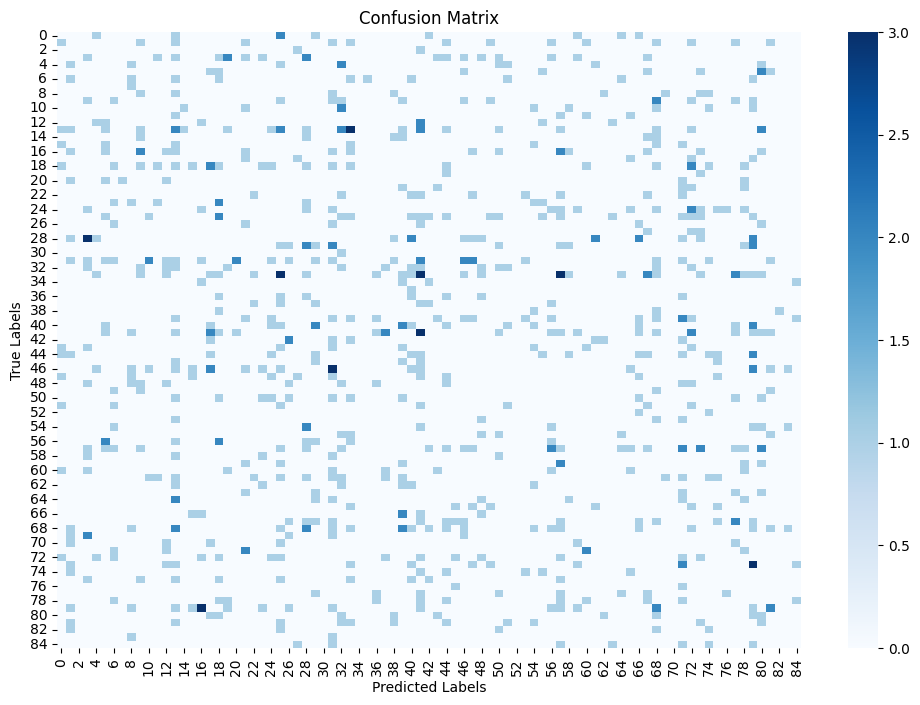

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
